In [1]:

import array
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark import SparkContext
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.mllib.regression import LabeledPoint
import numpy as np
#import scipy.sparse as sps
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.classification import SVMWithSGD, SVMModel, NaiveBayes
from pyspark.mllib.evaluation import BinaryClassificationMetrics


In [2]:
#textfile=sc.textFile('hdfs://0.0.0.0:9000/user/weatherAUS.csv')

In [2]:
file_location = "hdfs://0.0.0.0:9000/user/weatherAUS.csv"

In [3]:
from pyspark.sql import SparkSession 
spark = SparkSession.builder.master("local[*]").getOrCreate()


In [4]:
df = spark.read.option('header','true').option('inferSchema','true').csv(file_location)

In [5]:
display(df)

DataFrame[Date: string, Location: string, MinTemp: string, MaxTemp: string, Rainfall: string, Evaporation: string, Sunshine: string, WindGustDir: string, WindGustSpeed: string, WindDir9am: string, WindDir3pm: string, WindSpeed9am: string, WindSpeed3pm: string, Humidity9am: string, Humidity3pm: string, Pressure9am: string, Pressure3pm: string, Cloud9am: string, Cloud3pm: string, Temp9am: string, Temp3pm: string, RainToday: string, RISK_MM: double, RainTomorrow: string]

In [7]:
for i in df.columns:
  
  df.groupBy(i).count().orderBy("count", ascending=False).show(10)

+----------+-----+
|      Date|count|
+----------+-----+
|2016-07-06|   49|
|2013-03-14|   49|
|2014-03-17|   49|
|2016-08-17|   49|
|2017-05-14|   49|
|2016-09-11|   49|
|2014-05-27|   49|
|2017-05-11|   49|
|2014-07-14|   49|
|2016-08-08|   49|
+----------+-----+
only showing top 10 rows

+------------+-----+
|    Location|count|
+------------+-----+
|    Canberra| 3418|
|      Sydney| 3337|
|       Perth| 3193|
|      Darwin| 3192|
|      Hobart| 3188|
|    Brisbane| 3161|
|    Adelaide| 3090|
|     Bendigo| 3034|
|  Townsville| 3033|
|AliceSprings| 3031|
+------------+-----+
only showing top 10 rows

+-------+-----+
|MinTemp|count|
+-------+-----+
|    9.6|  883|
|     11|  883|
|   10.2|  880|
|   10.5|  867|
|   10.8|  860|
|      9|  853|
|     12|  850|
|     10|  849|
|     13|  844|
|   10.4|  842|
+-------+-----+
only showing top 10 rows

+-------+-----+
|MaxTemp|count|
+-------+-----+
|     20|  871|
|   19.8|  829|
|     19|  827|
|   20.4|  820|
|   20.8|  804|
|   19.9| 

In [6]:
data_df=df.drop('Date','Location','Evaporation','Sunshine','Cloud9am',"Cloud3pm")

In [7]:
from pyspark.ml.feature import StringIndexer
def transform_cat_to_num(col,data):
  
  indexer = StringIndexer(inputCol=col, outputCol=col+"Index") 
  indexed = indexer.fit(data).transform(data)
  return indexed

In [8]:
data_cleaning=transform_cat_to_num("WindGustDir",data_df)
data_cleaning=transform_cat_to_num("WindDir9am",data_cleaning)
data_cleaning=transform_cat_to_num("WindDir3pm",data_cleaning)
data_cleaning=transform_cat_to_num("RainToday",data_cleaning)
data_cleaning=transform_cat_to_num("RainTomorrow",data_cleaning)

In [9]:
d=data_cleaning.where("RainTodayIndex!=2")

In [10]:
d=d.drop("WindGustDir","WindDir9am","WindDir3pm","RainToday","RainTomorrow")

In [11]:
from pyspark.sql.functions import explode,regexp_extract,col
d=d.filter(col('Rainfall') != 'NA')
d=d.filter(col('windSpeed9am') != 'NA')
d=d.filter(col('windSpeed3pm') != 'NA')
d=d.filter(col('humidity3pm') != 'NA')
d=d.filter(col('pressure9am') != 'NA')
d=d.filter(col('pressure3pm') != 'NA')
d=d.filter(col('temp9am') != 'NA')
d=d.filter(col('temp3pm') != 'NA')

In [12]:
d.count()

124218

In [13]:
from pyspark.sql.types import DoubleType
def change_type(d):
    for i in d.columns:
        d = d.withColumn(i, d[i].cast(DoubleType()))
    return d

In [14]:
dFrame=change_type(d)

In [15]:
newDF=dFrame.na.drop()

In [16]:
newDF.count()

119590

In [17]:
rdd=newDF.rdd.map(list)

In [18]:
target_0=rdd.filter(lambda line:line[-1]==0)

In [19]:
target_0.count()

93403

In [20]:
target_1=rdd.filter(lambda line:line[-1]==1)

In [21]:
target_1.count()

26187

In [26]:
#ploting num target classes

<Container object of 2 artists>

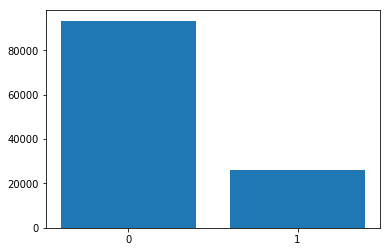

In [25]:
import matplotlib.pyplot as plt
x=["0","1"]
y=[target_0.count(),target_1.count()]
plt.bar(x,y)

In [22]:
def extract_label(line):
    return int(line[-1])

In [23]:
def extract_features_nb(line):
    
    l = []
    for i in line[:17]:
        if i == "NA":
            l=l+[0]
        elif float(i) < 0:
            l=l+[0]
        else:
            l=l+[i]
    return np.array(l)

In [24]:
import numpy as np
def extract_features_dt(line):
    
    l = []
    for i in line[:17]:
        if i != "NA":
            l=l+[i]
        else:
            l=l+[0]
    return np.array(l)

In [25]:
# Create a view or table
from pyspark.mllib.regression import LabeledPoint
data_feat_lab_dt=rdd.map(lambda line:LabeledPoint(extract_label(line),extract_features_dt(line)))

In [26]:
data_feat_lab_dt.first()

LabeledPoint(0.0, [13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0.0,0.0,7.0,7.0,0.0])

In [27]:
(training_dt, test_dt) = data_feat_lab_dt.randomSplit([0.8, 0.2])

In [ ]:
#logistic regression

In [ ]:
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.classification import SVMWithSGD, SVMModel, NaiveBayes
LogReg=LogisticRegressionWithSGD.train(training_dt,iterations=10, regParam=0.03)


In [ ]:
labelsAndPreds1 = training_dt.map(lambda p: (p.label, LogReg.predict(p.features)))
trainAcc = labelsAndPreds1.filter(lambda x:x[0]==x[1]).count() / float(training_dt.count())
print("Training acc for LR = " + str(trainAcc))


In [ ]:
labelsAndPreds1 = test_dt.map(lambda p: (p.label, LogReg.predict(p.features)))
testAcc = labelsAndPreds1.filter(lambda x:x[0]==x[1]).count() / float(test_dt.count())
print("Test acc for LR = " + str(testAcc))



In [ ]:
def tuning_logReg_rate(training,test,learning_rate):
    n
    for i in range(100,1001):
        if i%100==0:
            
            (training_dt, test_dt) = data_feat_lab_dt.randomSplit([0.8, 0.2])
             LogReg=LogisticRegressionWithSGD.train(training,iterations=i, regParam=learning_rate)
            labelsAndPreds1 = training.map(lambda p: (p.label, LogReg.predict(p.features)))
            trainErr1 = labelsAndPreds1.filter(lambda x:x[0]==x[1]).count() / float(training.count())
            print("Training acc for LR for iteration "+str(i/10)+" is " +str(trainErr1))
            labelsAndPreds1 = test.map(lambda p: (p.label, LogReg.predict(p.features)))
            testErr1 = labelsAndPreds1.filter(lambda x:x[0]==x[1]).count() / float(test.count())
            print("Test acc for LR for iteration "+str(i/10)+" is " +str(testErr1))

In [ ]:
tuning_logReg_rate(training_dt,test_dt,0.05)

In [ ]:
#naive bayes

In [ ]:
data_feat_lab_nb=rdd.map(lambda line:LabeledPoint(extract_label(line),extract_features_nb(line)))
(train_data_nb,test_data_nb)= data_feat_lab_nb.randomSplit([0.8, 0.2])
nbModel = NaiveBayes.train(train_data_nb)

In [ ]:

labelsAndPreds1 = train_data_nb.map(lambda p: (p.label, nbModel.predict(p.features)))
trainErr1 = labelsAndPreds1.filter(lambda x:x[0]==x[1]).count() / float(train_data_nb.count())
print("Training acc for LR = " + str(trainErr1))

In [ ]:

labelsAndPreds1 = test_data_nb.map(lambda p: (p.label, nbModel.predict(p.features)))
testErr1 = labelsAndPreds1.filter(lambda x:x[0]==x[1]).count() / float(test_data_nb.count())
print("Test acc for LR = " + str(testErr1))

In [ ]:
#decision tree

In [ ]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
model = DecisionTree.trainClassifier(training_dt, numClasses=2, categoricalFeaturesInfo={},
                                     impurity='gini', maxDepth=5, maxBins=32)

In [ ]:
predictions = model.predict(test_dt.map(lambda x: x.features))
labelsAndPredictions = test_dt.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(
    lambda lp: lp[0] == lp[1]).count() / float(test_dt.count())
print('Test Accuracy decision tree = ' + str(testErr))

In [ ]:
#regression

In [28]:
x=newDF.select('MinTemp','MaxTemp','Humidity9am','Humidity3pm','Pressure3pm','Temp9am',"Temp3pm")
display(x)

DataFrame[MinTemp: double, MaxTemp: double, Humidity9am: double, Humidity3pm: double, Pressure3pm: double, Temp9am: double, Temp3pm: double]

In [29]:
rdd_rg=x.rdd.map(list)

In [30]:
def extract_label_rg(line):
    return int(line[-1])

In [31]:
import numpy as np
def extract_features_rg(line):
    
    l = []
    for i in line[:6]:
        if i != "NA":
            l=l+[i]
        else:
            l=l+[0]
    return np.array(l)

In [32]:
rdd_rg.first()

[13.4, 22.9, 71.0, 22.0, 1007.1, 16.9, 21.8]

In [33]:
gg=rdd_rg.map(lambda line:extract_features_rg(line))

In [34]:
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.util import MLUtils

In [35]:
scaler1 = StandardScaler().fit(rdd_rg)

In [36]:
data1 = (scaler1.transform(rdd_rg))

In [37]:
data1.first()

DenseVector([2.1044, 3.2777, 3.7116, 1.0632, 143.4736, 2.6204, 3.1905])

In [38]:
data_feat_lab_rg=data1.map(lambda line:LabeledPoint(extract_label_rg(line),extract_features_rg(line)))

In [39]:
data_feat_lab_rg.first()

LabeledPoint(3.0, [2.10442434736,3.27771215697,3.71158873387,1.06322387427,143.473602918,2.62038996989])

In [ ]:
(train_rg, test_rg) = data_feat_lab_rg.randomSplit([0.8, 0.2])
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD
LRmodel = LinearRegressionWithSGD.train(train_rg, iterations=100, step=0.00000001)

In [ ]:
valuesAndPreds = test_rg.map(lambda p: (p.label, LRmodel.predict(p.features)))
MSE = valuesAndPreds \
    .map(lambda vp: (vp[0] - vp[1])**2) \
    .reduce(lambda x, y: x + y) / valuesAndPreds.count()
print("Mean Squared Error = " + str(MSE))


In [ ]:
c=LRmodel.predict(test_rg.map(lambda x:x.features))

In [ ]:
c.take(3)

In [ ]:
test_rg.first()

In [ ]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel

In [ ]:
LRTmodel = DecisionTree.trainRegressor(train_rg, categoricalFeaturesInfo={},
                                    impurity='variance', maxDepth=5, maxBins=32)


In [ ]:
predictions = LRTmodel.predict(test_rg.map(lambda x: x.features))
labelsAndPredictions = test_rg.map(lambda lp: lp.label).zip(predictions)
testMSE = labelsAndPredictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(test_rg.count())
print('Test Mean Squared Error = ' + str(testMSE))

In [ ]:
c=LRTmodel.predict(test_rg.map(lambda x:x.features))


In [ ]:
test_rg.take(6)

In [ ]:
c.take(6)

In [ ]:
#clustering

In [ ]:
from numpy import array
from math import sqrt

from pyspark.mllib.clustering import KMeans, KMeansModel
display(newDF)

In [ ]:
import numpy as np
def extract_features_cl(line):
    
    l = []
    for i in line[:16]:
        if i != "NA":
            l=l+[i]
        else:
            l=l+[0]
    return np.array(l)

In [ ]:
datacl=rdd.map(lambda line:extract_features_cl(line))

In [ ]:
from pyspark.mllib.clustering import KMeans, KMeansModel
clusters = KMeans.train(datacl, 2, maxIterations=100, initializationMode="random")

In [ ]:
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = datacl.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

In [ ]:
cl_pred=clusters.predict(datacl.map(lambda x:x))

In [ ]:
#normalization

In [ ]:
scaler_cl = StandardScaler().fit(datacl)
data1_cl = (scaler_cl.transform(datacl))

In [ ]:
data1_cl.first()

In [ ]:
from pyspark.mllib.clustering import KMeans, KMeansModel
clusters = KMeans.train(data1_cl, 2, maxIterations=100, initializationMode="random")

def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = data1_cl.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

In [ ]:
#tuning_clustering

In [ ]:
for k in range(1,20):
    clusters = KMeans.train(data1_cl, k, maxIterations=100, initializationMode="random")
    WSSSE = data1_cl.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print("K= " +str(k))
    print("Within Set Sum of Squared Error = " + str(WSSSE))

In [ ]:
datacl_new=rdd_rg.map(lambda line:extract_features_cl(line))

In [ ]:
from pyspark.mllib.clustering import KMeans, KMeansModel
clusters = KMeans.train(datacl_new, 2, maxIterations=100, initializationMode="random")

In [ ]:
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = datacl_new.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))